In [1]:
!pip install mido

import numpy as np
import mido
import os
import gc
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import math
from matplotlib.colors import ColorConverter
from scipy.sparse import dok_matrix, csr_matrix, save_npz, load_npz

filename = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/note_values.p'
with open(filename, 'rb') as fp:
    note_values = pickle.load(fp)

dataset_df = pd.read_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/dataset.p')
available_df = pd.read_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/dataset-available-Tr.p')

     |████████████████████████████████| 61kB 1.9MB/s 


In [2]:
class MidiFile(mido.MidiFile):

    def __init__(self, filename):
        mido.MidiFile.__init__(self, filename)
        self.sr = 10
        self.meta = {}
        self.events = self.get_events()

    def get_events(self):
        mid = self
        events = [[] for x in range(16)]
        # Iterate all event in the midi and extract to 16 channel form
        for track in mid.tracks:
            for msg in track:
                try:
                    channel = msg.channel
                    events[channel].append(msg)
                except AttributeError:
                    try:
                        if type(msg) != type(mido.UnknownMetaMessage):
                            self.meta[msg.type] = msg.dict()
                        else:
                            pass
                    except:
                        print("error",type(msg))
        return events

    def get_roll(self,merge_channels=False):
        events = self.get_events()
        # Identify events, then translate to piano roll
        # choose a sample ratio(sr) to down-sample through time axis
        sr = self.sr
        # compute total length in tick unit
        length = self.get_total_ticks()
        # allocate memory to numpy array
        roll = np.zeros((16, 128, length // sr), dtype="int8")
        # use a register array to save the state(no/off) for each key
        note_register = [int(-1) for x in range(128)]
        # use a register array to save the state(program_change) for each channel
        timbre_register = [1 for x in range(16)]

        for idx, channel in enumerate(events):
            time_counter = 0
            volume = 100
            # Volume would change by control change event (cc) cc7 & cc11
            # Volume 0-100 is mapped to 0-127
            for msg in channel:
                if msg.type == "control_change":
                    if msg.control == 7:
                        volume = msg.value
                        # directly assign volume
                    if msg.control == 11:
                        volume = volume * msg.value // 127
                        # change volume by percentage                   
                if msg.type == "program_change":
                    timbre_register[idx] = msg.program

                if msg.type == "note_on":
                    note_on_start_time = time_counter // sr
                    note_on_end_time = (time_counter + msg.time) // sr
                    intensity = volume * msg.velocity // 127
					# When a note_on event *ends* the note start to be play 
					# Record end time of note_on event if there is no value in register
					# When note_off event happens, we fill in the color
                    if note_register[msg.note] == -1:
                        note_register[msg.note] = (note_on_end_time,intensity)
                    else:
					# When note_on event happens again, we also fill in the color
                        old_end_time = note_register[msg.note][0]
                        old_intensity = note_register[msg.note][1]
                        roll[idx, msg.note, old_end_time: note_on_end_time] = old_intensity
                        note_register[msg.note] = (note_on_end_time,intensity)

                if msg.type == "note_off":
                    note_off_start_time = time_counter // sr
                    note_off_end_time = (time_counter + msg.time) // sr
                    note_on_end_time = note_register[msg.note][0]
                    intensity = note_register[msg.note][1]
					# fill in color
                    roll[idx, msg.note, note_on_end_time:note_off_end_time] = intensity
                    note_register[msg.note] = -1  # reinitialize register
                time_counter += msg.time

            # if there is a note not closed at the end of a channel, close it
            for key, data in enumerate(note_register):
                if data != -1:
                    note_on_end_time = data[0]
                    intensity = data[1]
                    # print(key, note_on_end_time)
                    note_off_start_time = time_counter // sr
                    roll[idx, key, note_on_end_time:] = intensity
                note_register[idx] = -1
        if merge_channels==True:
            roll = np.sum(roll,axis=0)
        return roll
    
    def get_transposed_roll(self,interval:int):
        if np.abs(interval) < 20:
            roll = self.get_roll()
            t_roll = np.zeros_like(roll)
            if interval>=0:
                for k1 in range(roll.shape[0]):
                    for k2 in range(roll.shape[1]-interval):
                        for k3 in range(roll.shape[2]):
                            t_roll[k1,k2+interval,k3] = roll[k1,k2,k3]
            else:
                for k1 in range(roll.shape[0]):
                    for k2 in range(-interval,roll.shape[1]):
                        for k3 in range(roll.shape[2]):
                            t_roll[k1,k2+interval,k3] = roll[k1,k2,k3]

        else:
            print("Not a valid tranposing")
        return t_roll

    def get_cropped_roll(self):
        pass

    def get_range(self):
        roll = self.get_roll()
        idxs = np.where(roll>0)
        range = (np.min(idxs[1]),np.max(idxs[1]))
        return range

    def get_roll_image(self):
        roll = self.get_roll()
        plt.ioff()
        K = 16
        transparent = ColorConverter.to_rgba('black')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / K, 1, 1)), alpha=1) for i in range(K)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 128) for i in
                 range(K)]
        for i in range(K):
            cmaps[i]._init()  # create the _lut array, with rgba values
            # create your alpha array and fill the colormap with them.
            # here it is progressive, but you can create whathever you want
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            cmaps[i]._lut[:, -1] = alphas

        fig = plt.figure(figsize=(4, 3))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
        a1.set_facecolor("black")
        array = []
        for i in range(K):
            try:
                img = a1.imshow(roll[i], interpolation='nearest', cmap=cmaps[i], aspect='auto')
                array.append(img.get_array())
            except IndexError:
                pass
        return array

    def draw_roll(self,fig,a1,filename:str,just_image=True,show=True,transposed=0):
        if transposed == 0:
            roll = self.get_roll()
        else:
            roll = self.get_transposed_roll(transposed)
        a1.axis("equal")
        #a1.set_facecolor("white")
        a1.set_facecolor('black')
        # change unit of time axis from tick to second
        tick = self.get_total_ticks()
        second = mido.tick2second(tick, self.ticks_per_beat, self.get_tempo())
        if second > 10:
            x_label_period_sec = second // 10
        else:
            x_label_period_sec = second / 10  # ms
        x_label_interval = mido.second2tick(x_label_period_sec, self.ticks_per_beat, self.get_tempo()) / self.sr
        if just_image==False:                
            a1.set_xticks([int(x * x_label_interval) for x in range(20)], [round(x * x_label_period_sec, 2) for x in range(20)])
            # change scale and label of y axis
            a1.set_yticks([y*16 for y in range(8)], [y*16 for y in range(8)])
        else:
            a1.set_xticks([])
            a1.set_yticks([])
        # build colors
        channel_nb = 16  # <--- MODIFICAR PARA QUE NO HAGA DISTINCIÓN ENTRE LOS CANALES
        transparent = ColorConverter.to_rgba('white')
        # colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / channel_nb, 1, 1)), alpha=1) for i in range(channel_nb)]
        # cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 128) for i in
        #          range(channel_nb)]
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / 1, 1, 1)), alpha=1) for i in range(channel_nb)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 128) for i in
                 range(channel_nb)]
        # build color maps
        for i in range(channel_nb):
            cmaps[i]._init()
            # create your alpha array and fill the colormap with them.
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            # create the _lut array, with rgba values
            cmaps[i]._lut[:, -1] = alphas

        for i in range(channel_nb):
            try:
                a1.imshow(roll[i], origin="lower", interpolation='nearest', cmap=cmaps[i], aspect='auto')
            except IndexError:
                pass
        fig.savefig(filename,dpi=200)
        a1.cla()
        
    def get_tempo(self):
        try:
            return self.meta["set_tempo"]["tempo"]
        except:
            return 500000

    def get_total_ticks(self):
        max_ticks = 0
        for channel in range(16):
            ticks = sum(msg.time for msg in self.events[channel])
            if ticks > max_ticks:
                max_ticks = ticks
        return max_ticks

In [3]:
def msj(k,width):
    if (k+1)%width > 0:
        print(k, end='Ϟ ')
    else:
        print(k,'Ϟ',end='\r')

def t_msj(k,t,width):
    if (k+1)%width > 0:
        print(str(k)+'/'+str(t), end=' ')
    else:
        print(k,end='\r')


def DitchExtension(name):
    ks = [i for i, x in enumerate(name) if x == '.']
    if len(ks)>0:
        return name[:ks[-1]]
    if len(ks)==0:
        print("No tenía extensión")
        return name

In [ ]:
# available_df = dataset_df[dataset_df['Image']==True].copy()
N = available_df.shape[0]
print(N)
max_t = 340522
max_note = 108
min_note = 21 
# dim_x = (max_note-min_note+1)*max_t
dim_x = (max_note-min_note+1)*sample_duration
print(dim_x)

1893
44000


# Combinar dos matrices sparse

In [ ]:
Top_sparse = load_npz('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/X_master.npz')
Middle_sparse = load_npz('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/X_master_middle.npz')

In [ ]:
SoFar_sparse = Top_sparse + Middle_sparse

In [ ]:
sums_by_row = SoFar_sparse.sum(axis=1)
idxs = np.where(sums_by_row>0)
idxs[0]

array([   0,    1,    2, ..., 1297, 1298, 1299])

In [ ]:
path = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/'
fname = path + 'X_master.npz'
save_npz(fname,SoFar_sparse)

Leer la matriz $X_\text{master}$ y detectar dónde vamos

In [ ]:
X_master = load_npz('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/X_master.npz')
print(type(X_master))
#X_master = X_sparse.todok()
X_master.shape

<class 'scipy.sparse.csc.csc_matrix'>


(1893, 29965936)

Este código encuentra dónde nos quedamos

In [ ]:
sums_by_row = X_master.sum(axis=1)

In [ ]:
print(type(sums_by_row))
print(sums_by_row.shape)
idxs = np.where(sums_by_row>0)
idxs[0]
del sums_by_row
gc.collect()

<class 'numpy.matrix'>
(1893, 1)


Este código continúa donde nos quedamos

In [ ]:
idxs_to_do = available_df.index.to_list()
print(len(idxs_to_do),N)

1893 1893


In [ ]:
path = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/'

for j in range(1500,N):
    try:
        full_midi_name = available_df.loc[idxs_to_do[j],'Midi_Path']
        mid = MidiFile(full_midi_name)
        roll = mid.get_roll(merge_channels=True)
        roll = roll[21:109,:]
        row = roll.flatten()
        row.resize((dim_x,))
        non_zero_idxs = np.where(row>0)
        for k in non_zero_idxs:
            SoFar_sparse[j,k] = row[k]
        t_msj(j+1,N,10)
        del mid
    except:
        print("!")
# X = X_master_middle.tocsc()
fname = path + 'X_master_aug.npz'
save_npz(fname,SoFar_sparse)


1870/1893 1871/1893 1872/1893 1873/1893 1874/1893 1875/1893 1876/1893 1877/1893 1878/1893 !


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


1880/1893 1881/1893 !
1883/1893 1884/1893 !
1890/1893 1891/1893 1892/1893 1893/1893 

# Generar y guardar todos los arreglos roll

In [ ]:
available_df.to_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/dataset-available-Tr.p')

In [ ]:
available_df['Roll_array'] = False
available_df.head(3)

,img_Filename,Composer,Period,Image,Broken,root_Filename,canonical_title,Img_Path,Midi_Path,Trs,Roll_array
0,chpn_op25_e2.png,Chopin,Romanticism,True,False,chpn_op25_e2,,/content/drive/My Drive/Diplomado Python/Noteb...,/content/drive/My Drive/Diplomado Python/Noteb...,True,False
1,chpn_op25_e4.png,Chopin,Romanticism,True,False,chpn_op25_e4,,/content/drive/My Drive/Diplomado Python/Noteb...,/content/drive/My Drive/Diplomado Python/Noteb...,True,False
2,chp_op18.png,Chopin,Romanticism,True,False,chp_op18,,/content/drive/My Drive/Diplomado Python/Noteb...,/content/drive/My Drive/Diplomado Python/Noteb...,True,False


In [ ]:
path = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/MIDIs'
arrays_path = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/Rolls-arrays/'

for j in range(N):
    full_midi_name = available_df.loc[j,'Midi_Path']
    root_fname = available_df.loc[j,'root_Filename']
    done = available_df.loc[j,'Roll_array']
    if done!=True:
        try:
            mid = MidiFile(full_midi_name)
            roll = mid.get_roll(merge_channels=True)
            roll = roll[21:109,:]
            roll_sparse = csr_matrix(roll)
            fname = arrays_path + root_fname
            save_npz(fname,roll_sparse)
            available_df.loc[j,'Roll_array'] = True
        except:
            print("error->",root_fname)

available_df.to_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/dataset-available-Tr.p')
print("Fertig...")
hechos = available_df[available_df['Roll_array']==True].shape[0]
print("Van",hechos,"hechos")

error-> prelude2
error-> prelude7
error-> prelude8
Fertig...
Van 1890 hechos


# Sólo considerar una porción de todo el roll y con eso, clasificar

In [13]:
arrays_available_df = available_df.drop(index=[1890,1891,1892])
arrays_available_df

,img_Filename,Composer,Period,Image,Broken,root_Filename,canonical_title,Img_Path,Midi_Path,Trs,Roll_array
0,chpn_op25_e2.png,Chopin,Romanticism,True,False,chpn_op25_e2,,/content/drive/My Drive/Diplomado Python/Noteb...,/content/drive/My Drive/Diplomado Python/Noteb...,True,True
1,chpn_op25_e4.png,Chopin,Romanticism,True,False,chpn_op25_e4,,/content/drive/My Drive/Diplomado Python/Noteb...,/content/drive/My Drive/Diplomado Python/Noteb...,True,True
2,chp_op18.png,Chopin,Romanticism,True,False,chp_op18,,/content/drive/My Drive/Diplomado Python/Noteb...,/content/drive/My Drive/Diplomado Python/Noteb...,True,True
3,chpn_op7_1.png,Chopin,Romanticism,True,False,chpn_op7_1,,/content/drive/My Drive/Diplomado Python/Noteb...,/content/drive/My Drive/Diplomado Python/Noteb...,True,True
4,chpn_op35_4.png,Chopin,Romanticism,True,False,chpn_op35_4,,/content/drive/My Drive/Diplomado Python/Noteb...,/content/drive/My Drive/Diplomado Python/Noteb...,True,True
...,...,...,...,...,...,...,...,...,...,...,...
1885,sin2.png,partitas,Baroque,True,False,sin2,,/content/drive/My Drive/Diplomado Python/Noteb...,/content/drive/My Drive/Diplomado Python/Noteb...,True,True
1886,fugue16.png,wtcbki,Baroque,True,False,fugue16,,/content/drive/My Drive/Diplomado Python/Noteb...,/content/drive/My Drive/Diplomado Python/Noteb...,True,True
1887,fugue14.png,wtcbki,Baroque,True,False,fugue14,,/content/drive/My Drive/Diplomado Python/Noteb...,/content/drive/My Drive/Diplomado Python/Noteb...,True,True
1888,fugue18.png,wtcbki,Baroque,True,False,fugue18,,/content/drive/My Drive/Diplomado Python/Noteb...,/content/drive/My Drive/Diplomado Python/Noteb...,True,True


In [ ]:
import scipy
import warnings
warnings.filterwarnings("ignore", category=scipy.sparse.SparseEfficiencyWarning)

In [ ]:
arrays_path = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/Rolls-arrays/'
short_arrays_path = ''
sample_duration = 500
max_note = 108
min_note = 21 
dim_x = (max_note-min_note+1)*sample_duration
dim_y = available_df[available_df['Roll_array']==True].shape[0]
X = csr_matrix((dim_y,dim_x))
print(X.shape)

for k in available_df.index.to_list():
    root_fname = available_df.loc[k,'root_Filename']
    filename = arrays_path + root_fname + '.npz'
    try:
        roll_sp = load_npz(filename)
        roll = roll_sp.todense()
        roll = roll[:,:sample_duration]
        row = roll.flatten()
        non_zero_idxs = np.where(row!=0)
        for j in non_zero_idxs[1]:
            X[k,j] = row[0,j]
        t_msj(k+1,dim_y,10)
    except:
        print(root_fname,"not found")

path = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/'
fname = path + 'X_master_sample_500.npz'
save_npz(fname,X)

(1890, 44000)
1870/1890 1871/1890 1872/1890 1873/1890 1874/1890 1875/1890 1876/1890 1877/1890 1878/1890 prelude2 not found
1880/1890 1881/1890 prelude7 not found
1883/1890 1884/1890 prelude8 not found
1890/1890 fugue22 not found
fugue21 not found
fugue23 not found


In [5]:
fname = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/X_master_sample_500.npz'
X_sp = load_npz(fname)
X = X_sp.todense()
X.shape

(1890, 44000)

In [6]:
idxs = np.where(X!=0)
idxs

(array([   0,    0,    0, ..., 1889, 1889, 1889]),
 array([25112, 25113, 25114, ..., 28465, 28466, 28467]))

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_red = pca.fit_transform(X)

In [12]:
X_red.shape

(1890, 100)

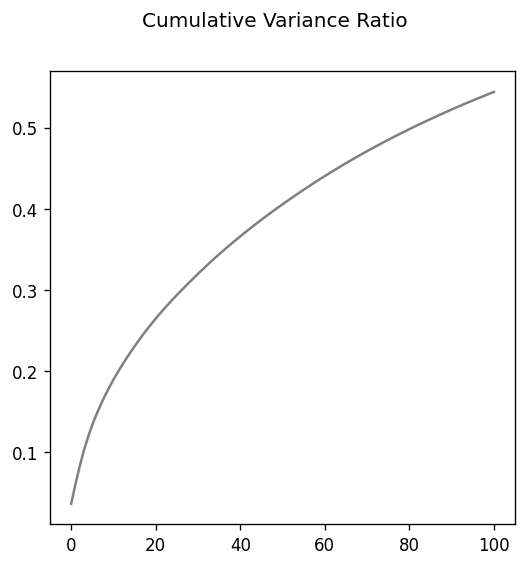

In [10]:
VRs = pca.explained_variance_ratio_
n = VRs.shape[0]
cum_exp_variance = np.cumsum(VRs)

plt.figure(figsize=(5,5),dpi=120)
plt.suptitle("Cumulative Variance Ratio")
plt.plot(np.linspace(0,n,num=n),cum_exp_variance,color='gray')
plt.savefig('PCA-100D cumulative variance ratio.png')
plt.show()

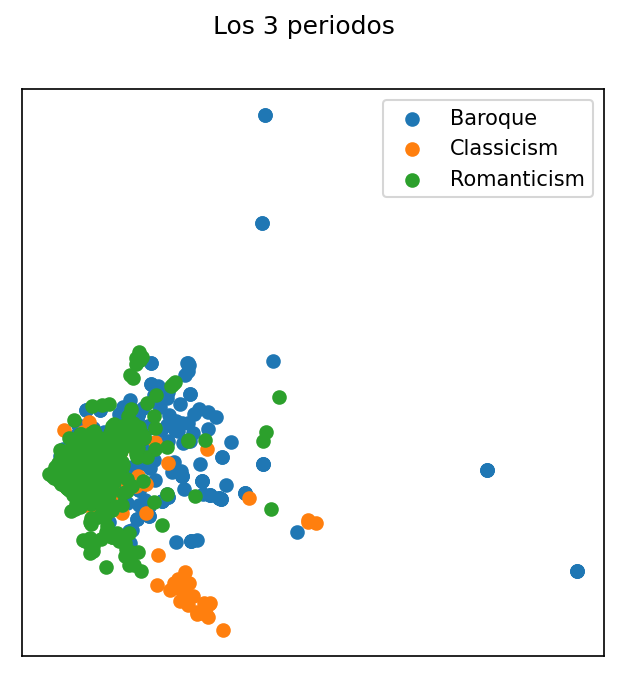

In [14]:
prds = ['Baroque','Classicism','Romanticism']
idxs = [ arrays_available_df[arrays_available_df['Period'] == prd].index.to_list()
                    for prd in prds ]
plt.figure(figsize=(5,5),dpi=150)
plt.suptitle("Los 3 periodos")
for k,prd in enumerate(prds):
    plt.scatter(X_red[idxs[k],0],X_red[idxs[k],1],label=prd)
plt.xticks([])
plt.yticks([])
plt.legend()
plt.savefig('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/PCA2D-500samples.png')

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, multilabel_confusion_matrix, recall_score, precision_score

In [20]:
y = arrays_available_df['Period']
y = pd.get_dummies(y)
y.drop(columns=['Modern','Nationalism'],inplace=True)
y = y.to_numpy()
y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [30]:
print(arrays_available_df.loc[100:105,'root_Filename'])
print(y[100:106])

100    beethoven_hammerklavier_1
101                 pathetique_2
102                  waldstein_2
103                     appass_3
104           beethoven_opus90_2
105    beethoven_hammerklavier_2
Name: root_Filename, dtype: object
[[0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]]


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_red,y,test_size = 0.2, 
                                                    random_state=28)
print("Formas:")
print("Train:",X_train.shape,y_train.shape)
print("Test:",X_test.shape,y_test.shape)

Formas:
Train: (1512, 100) (1512, 3)
Test: (378, 100) (378, 3)


In [26]:
est = KNeighborsClassifier()
clf = MultiOutputClassifier(estimator=est)
clf.fit(X_train,y_train)
y_predicted = clf.predict(X_test)
print("RMSE:",mean_squared_error(y_test,y_predicted,squared=False))
print("Recall score:",recall_score(y_test,y_predicted,average='micro'))
print("Precision score:",precision_score(y_test,y_predicted,average='micro'))
cm = multilabel_confusion_matrix(y_test,y_predicted)
print(cm)

RMSE: 0.43033148291193524
Recall score: 0.6870026525198939
Precision score: 0.7378917378917379
[[[259  11]
  [ 59  49]]

 [[298   8]
  [ 43  29]]

 [[108  73]
  [ 16 181]]]


# PCA a la matriz 

In [ ]:
X_master = load_npz('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/X_master.npz')
print(type(X_master))
X_master.shape

<class 'scipy.sparse.csc.csc_matrix'>


(1893, 29965936)

In [ ]:
from sklearn.decomposition import SparsePCA, PCA, TruncatedSVD, MiniBatchSparsePCA

pca = TruncatedSVD(n_components=7)
# pca = MiniBatchSparsePCA(n_components=50)
X_red = pca.fit_transform(X_master)

In [ ]:
np.save('X_master_6D.npy',X_master)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation()
X_red = lda.fit_transform(X_master)

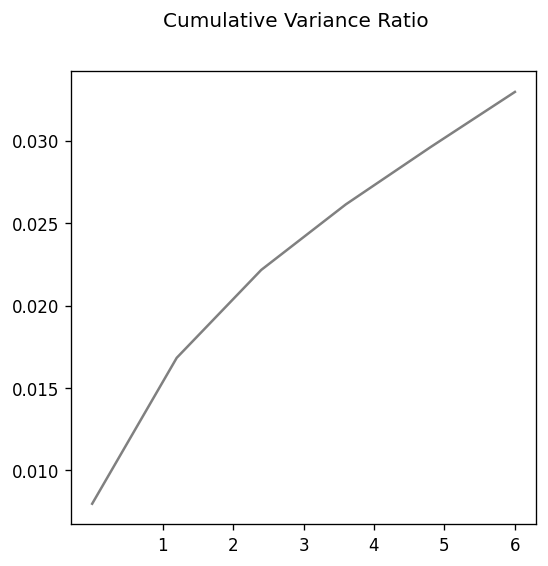

In [ ]:
VRs = pca.explained_variance_ratio_
n = VRs.shape[0]
cum_exp_variance = np.cumsum(VRs)

plt.figure(figsize=(5,5),dpi=120)
plt.suptitle("Cumulative Variance Ratio")
plt.plot(np.linspace(0,n,num=n),cum_exp_variance,color='gray')
ticks = [k+1 for k in range(n)]
plt.xticks(ticks)
plt.savefig('PCA-6D cumulative variance ratio.png')
plt.show()

In [ ]:
reset_available_df = available_df.copy()
reset_available_df.reset_index(inplace=True)
reset_available_df.drop(columns='index',inplace=True)
reset_available_df

In [ ]:
prds = ['Baroque','Classicism','Romanticism']
idxs = [ reset_available_df[reset_available_df['Period'] == prd].index.to_list() for prd in prds ]

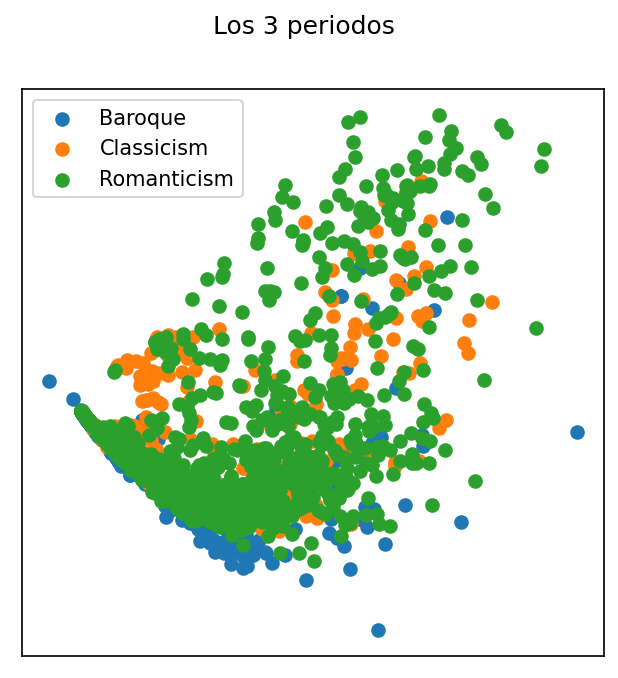

In [ ]:
plt.figure(figsize=(5,5),dpi=150)
plt.suptitle("Los 3 periodos")
for k,prd in enumerate(prds):
    plt.scatter(X_red[idxs[k],0],X_red[idxs[k],1],label=prd)
plt.xticks([])
plt.yticks([])
plt.legend()
plt.savefig('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/PCA.png')
plt.savefig('PCA-2d.png',dpi=150)

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


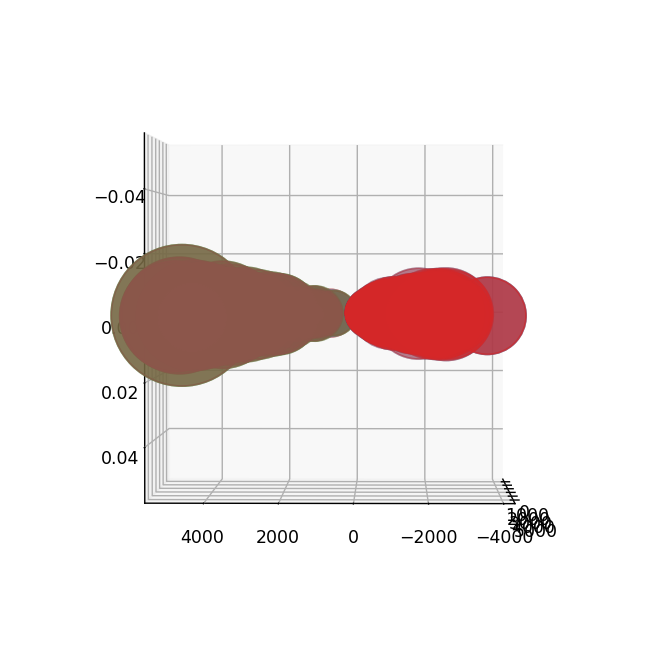

In [ ]:
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(5,5),dpi=125)
ax = Axes3D(fig)
def init():
    for k,prd in enumerate(prds):
        plt.scatter(X_red[idxs[k],0],X_red[idxs[k],1],X_red[idxs[k],2],
                    label=prd)
    return fig,

def animate(i):
    ax.view_init(elev=i, azim=i)
    return fig,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)

anim.save('PCA3D 2.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


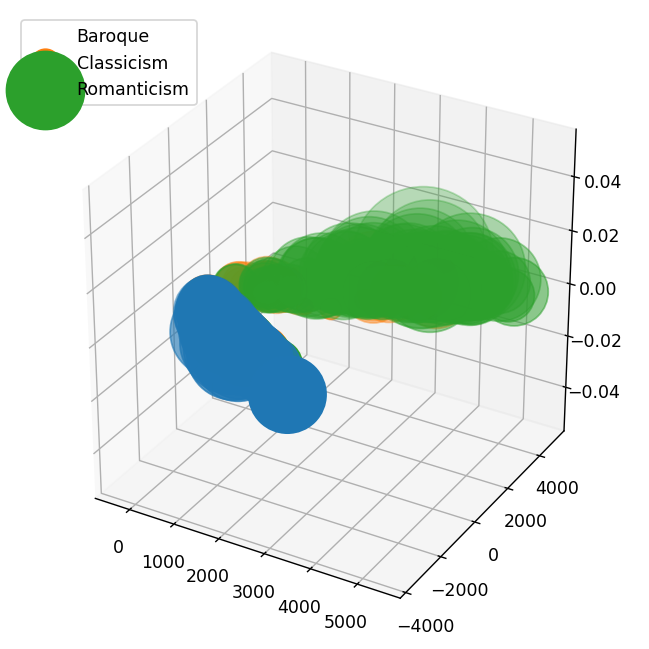

In [ ]:
fig = plt.figure(figsize=(5,5),dpi=125)
ax = Axes3D(fig)
for k,prd in enumerate(prds):
    plt.scatter(X_red[idxs[k],0],X_red[idxs[k],1],X_red[idxs[k],2],
                label=prd)
ax.legend(loc='upper left')
fig.show()

In [ ]:
roll_0 = rolls[0]
print(roll_0.shape)
roll_2d = np.sum(roll_0,axis=0)
print(roll_2d.shape)

(16, 128, 23424)
(128, 23424)


In [ ]:
js = np.where(roll_0>0)
print("Lowest & Highest:",np.min(js[1]),np.max(js[1])) 
print(js[0].shape,js[1].shape,js[2].shape)

Lowest & Highest: 26 98
(17880,) (17880,) (17880,)


In [ ]:
plt.imshow(X_master)
plt.show()

# Análisis Estadístico 

## Duraciones

El roll es un arreglo de 

16 (channels) x 128 (notas) x 177712 (duración... variable)

In [ ]:
rootdir = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/MIDIs'

duraciones = []
bad_files = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filename = os.path.join(subdir, file)
        try:
            mid = MidiFile(filename)
            roll = mid.get_roll()
            duraciones.append(roll.shape[2])
        except:
            bad_files.append(filename)
print("El promedio de duración es:",np.mean(duraciones))
print("Mínimo:",np.min(duraciones))
print("Máximo:",np.max(duraciones))

El promedio de duración es: 39449.06209637357
Mínimo: 566
Máximo: 340522


In [ ]:
print("Hay",len(bad_files),"midis raros")

In [ ]:
print(bad_files)

In [ ]:
plt.figure(dpi=120)
plt.hist(duraciones,color='gray',edgecolor='black')
plt.savefig('Histograma duraciones.png',dpi=120)

## Rango de notas

In [ ]:
rootdir = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/MIDIs'

maxs_mins = []
notes_played = np.array([])
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filename = os.path.join(subdir, file)
        try:
            mid_bar = MidiFile(filename)
            roll = mid_bar.get_roll()
            idxs = np.where(roll>0)
            maxs_mins.append((np.min(idxs[1]),np.max(idxs[1])))
            notes_played = np.concatenate([notes_played,idxs[1]])
        except:
            break

mean_low = np.mean([x[0] for x in maxs_mins])
mean_high = np.mean([x[1] for x in maxs_mins])
print("El promedio de nota más baja es:",mean_low," --->", note_values[math.floor(mean_low)])
print("El promedio de máximos es:",mean_high," --->", note_values[math.floor(mean_high)])
lowest = np.min([x[0] for x in maxs_mins])
highest = np.max([x[1] for x in maxs_mins])
print("Mínimo:",lowest," --->", note_values[math.floor(lowest)])
print("Máximo:",highest," --->", note_values[math.floor(highest)])

El promedio de nota más baja es: 29.491127647395537  ---> fa1
El promedio de máximos es: 93.72524327418432  ---> la6
Mínimo: 21  ---> la0
Máximo: 108  ---> do8


## Range of values

In [ ]:
rootdir = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/MIDIs'

max_min_values = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filename = os.path.join(subdir, file)
        try:
            mid_bar = MidiFile(filename)
            roll = mid_bar.get_roll()
            max_v = np.max(roll)
            min_v = np.min(roll) 
            max_min_values.append((max_v,min_v))
        except:
            break
lowest = np.min([x[0] for x in max_min_values])
highest = np.max([x[1] for x in max_min_values])
print("Mínimo valor en el roll:",lowest," --->", lowest)
print("Máximo valor en el roll:",highest," --->", highest)

Mínimo valor en el roll: 42  ---> 42
Máximo valor en el roll: 0  ---> 0


In [ ]:
plt.figure(dpi=120)
plt.hist(notes_played,color='gray',edgecolor='black')
ticks_to_use = [21,40,60,80,108]
labels_to_use = [note_values[x] for x in ticks_to_use]
plt.xticks(ticks=ticks_to_use, labels=labels_to_use)
plt.savefig('Histograma notas tocadas 2.png',dpi=120)

In [ ]:
available_df.to_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/dataset-images.p')